In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import glob
import numpy as np 
from os.path import join 

import seaborn as sns
import matplotlib.pyplot as plt
from scikits.bootstrap import ci

import sys
import os

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Palatino"]})
if sys.platform == "darwin":
    rc("text", usetex = True)

from vis import Visualization, parse_table, make_dfs, pbcc_results, return_asterisks

In [3]:
def pbcc_results(file, inmod, sex, setting, extra_pt=None):
    models = ["LogisticRegression", "LinearSVC", "SVC", "GradientBoostingClassifier"]

    df = pd.read_csv(join(file, "run.csv"))
    df = df.query("model in @models").query("technique == 'baseline' and io == 'X-y'")
    df = df[["model", "trial", "d2_conf_pred", "d2_pred", "d2_conf"]]

    df = df.assign(Dc = lambda x: x.d2_conf_pred - x.d2_pred)
    df = df.assign(Dp = lambda x: x.d2_conf_pred - x.d2_conf)
    df = df.assign(shared = lambda x: x.d2_conf_pred - x.Dc - x.Dp)
    df = df[["model", "trial", "Dc", "Dp", "shared"]]

    if os.path.isfile(join(file, "pt.csv")):
        dfpt = pd.read_csv(join(file, "pt.csv"))
        dfpt = dfpt.query("model in @models").query("technique == 'baseline' and io == 'X-y'")
        dfpt = dfpt[["model", "trial", "d2_conf_pred", "d2_pred", "d2_conf"]]
        dfpt = dfpt.assign(Dc = lambda x: x.d2_conf_pred - x.d2_pred)
        dfpt = dfpt.assign(Dp = lambda x: x.d2_conf_pred - x.d2_conf)
        dfpt = dfpt.assign(shared = lambda x: x.d2_conf_pred - x.Dc - x.Dp)
        dfpt = dfpt[["model", "trial", "Dc", "Dp", "shared"]]
    elif isinstance(extra_pt, pd.DataFrame):
        dfpt = extra_pt.query("model in @models").query("technique == 'baseline' and io == 'X-y'")
        dfpt = dfpt[["model", "trial", "d2_conf_pred", "d2_pred", "d2_conf"]]
        dfpt = dfpt.assign(Dc = lambda x: x.d2_conf_pred - x.d2_pred)
        dfpt = dfpt.assign(Dp = lambda x: x.d2_conf_pred - x.d2_conf)
        dfpt = dfpt.assign(shared = lambda x: x.d2_conf_pred - x.Dc - x.Dp)
        dfpt = dfpt[["model", "trial", "Dc", "Dp", "shared"]]
    else:
        dfpt = None


    dfn = pd.DataFrame(columns=["model", "setting", "inmod", "sex", "Dc_mean", "Dc_low", "Dc_high", "Dp_mean", "Dp_low", "Dp_high", \
                               "sh_mean", "sh_low", "sh_high", "Dp_pvalue"])

    for m in models:

        dfx = df.query("model == @m")

        Dc = dfx.Dc.values
        Dc_low, Dc_high = ci(Dc)
        Dc_mean = np.mean(Dc)

        Dp = dfx.Dp.values
        Dp_low, Dp_high = ci(Dp)
        Dp_mean = np.mean(Dp)
        
        if dfpt is not None:
            dfxpt = dfpt.query("model == @m")
            permvals = dfxpt.Dp.values
            if len(permvals) == 0:
                pvalue = np.nan
            else:
                C = sum(permvals > Dp_mean)
                pvalue = (C+1)/(len(permvals) + 1)
        else:
            pvalue = np.nan

        sh = dfx.shared.values
        sh_low, sh_high = ci(sh)
        sh_mean = np.mean(sh)

        row = pd.Series([m, setting, inmod, sex, Dc_mean, Dc_low, Dc_high, Dp_mean, Dp_low, Dp_high, sh_mean, sh_low, sh_high, pvalue], index=dfn.columns)

        dfn = dfn.append(row, ignore_index=True)


    return dfn

In [9]:
def pbcc_results(file, inmod, sex, setting, extra_pt=None):
    models = ["LogisticRegression", "LinearSVC", "SVC", "GradientBoostingClassifier"]

    df = pd.read_csv(join(file, "run.csv"))
    df = df.query("model in @models").query("technique == 'baseline' and io == 'X-y'")
    df = df[["model", "trial", "d2_conf_pred", "d2_pred", "d2_conf"]]

    df = df.assign(Dc = lambda x: x.d2_conf_pred - x.d2_pred)
    df = df.assign(Dp = lambda x: x.d2_conf_pred - x.d2_conf)
    df = df.assign(shared = lambda x: x.d2_conf_pred - x.Dc - x.Dp)
    df = df[["model", "trial", "Dc", "Dp", "shared"]]

    if os.path.isfile(join(file, "pt.csv")):
        dfpt = pd.read_csv(join(file, "pt.csv"))
        dfpt = dfpt.query("model in @models").query("technique == 'baseline' and io == 'X-y'")
        dfpt = dfpt[["model", "trial", "d2_conf_pred", "d2_pred", "d2_conf"]]
        dfpt = dfpt.assign(Dc = lambda x: x.d2_conf_pred - x.d2_pred)
        dfpt = dfpt.assign(Dp = lambda x: x.d2_conf_pred - x.d2_conf)
        dfpt = dfpt.assign(shared = lambda x: x.d2_conf_pred - x.Dc - x.Dp)
        dfpt = dfpt[["model", "trial", "Dc", "Dp", "shared"]]
    elif isinstance(extra_pt, pd.DataFrame):
        dfpt = extra_pt.query("model in @models").query("technique == 'baseline' and io == 'X-y'")
        dfpt = dfpt[["model", "trial", "d2_conf_pred", "d2_pred", "d2_conf"]]
        dfpt = dfpt.assign(Dc = lambda x: x.d2_conf_pred - x.d2_pred)
        dfpt = dfpt.assign(Dp = lambda x: x.d2_conf_pred - x.d2_conf)
        dfpt = dfpt.assign(shared = lambda x: x.d2_conf_pred - x.Dc - x.Dp)
        dfpt = dfpt[["model", "trial", "Dc", "Dp", "shared"]]
    else:
        dfpt = None

    cols = ["model", "setting", "inmod", "sex", "origin", "mean", "low", "high", "pvalue"]
    dfn = pd.DataFrame(columns=cols)

    for m in models:

        dfx = df.query("model == @m")

        Dc = dfx.Dc.values
        Dc_low, Dc_high = ci(Dc)
        Dc_mean = np.mean(Dc)
    
        r1 = [[m, setting, inmod, sex, "conf", Dc_mean, Dc_low, Dc_high, np.nan]]
        dfn = dfn.append(pd.DataFrame(r1, columns=cols), ignore_index=True)

        Dp = dfx.Dp.values
        Dp_low, Dp_high = ci(Dp)
        Dp_mean = np.mean(Dp)
        
        if dfpt is not None:
            dfxpt = dfpt.query("model == @m")
            permvals = dfxpt.Dp.values
            if len(permvals) == 0:
                pvalue = np.nan
            else:
                C = sum(permvals > Dp_mean)
                pvalue = (C+1)/(len(permvals) + 1)
        else:
            pvalue = np.nan
            
        r2 = [[m, setting, inmod, sex, "pred", Dp_mean, Dp_low, Dp_high, pvalue]]
        dfn = dfn.append(pd.DataFrame(r2, columns=cols), ignore_index=True)

        sh = dfx.shared.values
        sh_low, sh_high = ci(sh)
        sh_mean = np.mean(sh)
        
        r3 = [[m, setting, inmod, sex, "shared", sh_mean, sh_low, sh_high, np.nan]]
        dfn = dfn.append(pd.DataFrame(r3, columns=cols), ignore_index=True)

    return dfn

# FSS

In [10]:
idb = "../analysis/results/fs-stats_FU2-FU2_n789/20210226-2135"
prb = "../analysis/results/fs-stats_BL-FU2_n507/20210226-2203"

id1 = "../analysis/results/fs-stats_FU2-FU2_n403_sex1/20210226-2255"
pr1 = "../analysis/results/fs-stats_BL-FU2_n269_sex1/20210226-2242"

id0 = "../analysis/results/fs-stats_FU2-FU2_n386_sex0/20210226-2330"
pr0 = "../analysis/results/fs-stats_BL-FU2_n238_sex0/20210226-2318"

In [11]:
df_fss = pd.DataFrame()
df_fss = df_fss.append(pbcc_results(idb, "fss", "both", "id"))
df_fss = df_fss.append(pbcc_results(id1, "fss", "female", "id"))
df_fss = df_fss.append(pbcc_results(id0, "fss", "male", "id"))
df_fss = df_fss.append(pbcc_results(prb, "fss", "both", "pr"))
df_fss = df_fss.append(pbcc_results(pr1, "fss", "female", "pr"))
df_fss = df_fss.append(pbcc_results(pr0, "fss", "male", "pr"))

In [12]:
posz=0.4
lisz=0.7 
dodge = 0.4
c = sns.color_palette()
xtix = [r"$\Delta D^2_c$", r"$\Delta D^2_p$", r"$D^2_{p \cap c}$"]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


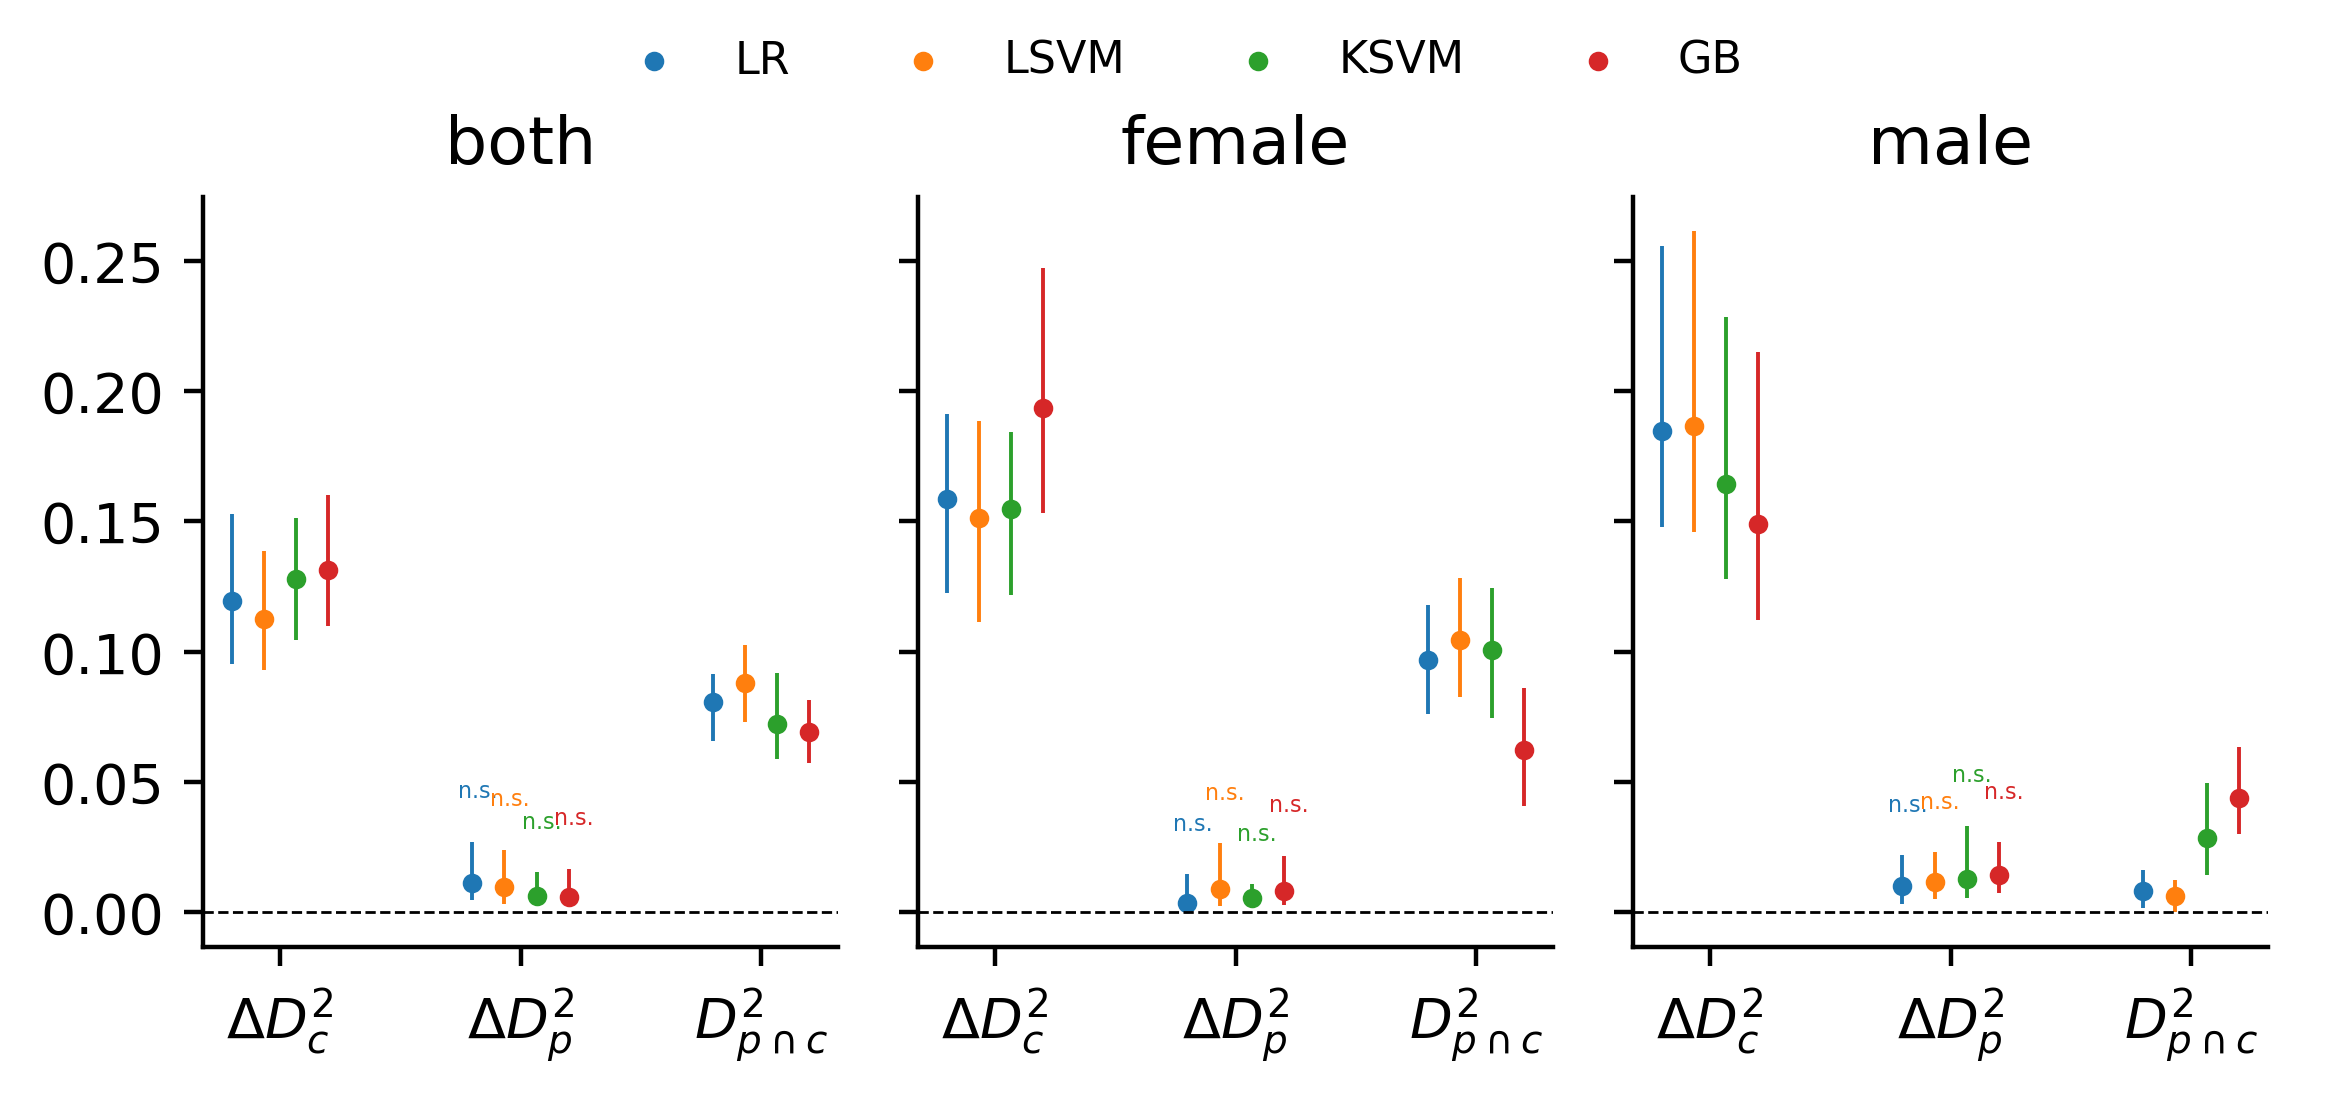

In [13]:
df = df_fss.query("setting == 'id'")

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(6.3, 3), dpi=400, sharex=True, sharey=True)

for i, sex in enumerate(["both", "female", "male"]):
    dfx = df.query("sex == @sex")

    a = sns.pointplot(x="origin", y="mean", hue="model", data=dfx,\
             dodge=dodge, join=False, ax=ax[i], scale=posz)
    a.legend_.remove()
    ax[i].set_xticklabels(xtix)
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].set_title(sex)
    ax[i].axhline(y=0, c='k', ls='--', lw=0.5)
    
    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean()
    
    # Add errorbars and significance stars 
    for k, orig in enumerate(dfx["origin"].unique()):
        for m, model in enumerate(dfx["model"].unique()):

            dfxx = dfx.query("model == '{}' and origin == '{}'".format(model, orig))
            test_score = dfxx["mean"].values[0]
            ci_low = dfxx["low"].values[0]
            ci_high = dfxx["high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(k+dodge_[m], test_score, yerr=err, c=c[m], elinewidth=lisz)
            
            pvalue = dfxx["pvalue"].values[0]
            if (not np.isnan(pvalue)):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(k+dodge_[m]-0.06, ci_high+0.017,  r"{}".format(ast), c=c[m], fontsize=4)
                else:
                    ax[i].text(k+dodge_[m], ci_high+0.01, r"{}".format(ast), c=c[m], fontsize=6)

    
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

handles, _ = ax[i].get_legend_handles_labels()
#handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.85)
plt.show()

# T1w

In [14]:
idb = "../analysis/results/T1w_FU2-FU2_n789_z0.525_d0/20210226-2358"
prb = "../analysis/results/T1w_BL-FU2_n507_z0.525_d0/20210227-0005"

id1 = "../analysis/results/T1w_FU2-FU2_n403_sex1_z0.525_d0/20210227-0048"
pr1 = "../analysis/results/T1w_BL-FU2_n269_sex1_z0.525_d0/20210227-0040"

id0 = "../analysis/results/T1w_FU2-FU2_n386_sex0_z0.525_d0/20210227-0111"
pr0 = "../analysis/results/T1w_BL-FU2_n238_sex0_z0.525_d0/20210227-0058"

In [15]:
df_pt = pd.DataFrame()
df_pt = df_pt.append(pd.read_csv("../analysis/results/T1w_FU2-FU2_n789_z0.525_d0/20210301-1022/pt.csv"))
df_pt = df_pt.append(pd.read_csv("../analysis/results/T1w_FU2-FU2_n789_z0.525_d0/20210227-0138/pt.csv").query("model !='SVC'"))

In [16]:
df_t1w = pd.DataFrame()
df_t1w = df_t1w.append(pbcc_results(idb, "T1w", "both", "id", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/T1w_FU2-FU2_n403_sex1_z0.525_d0/20210227-2224/pt.csv")
df_t1w = df_t1w.append(pbcc_results(id1, "T1w", "female", "id", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/T1w_FU2-FU2_n386_sex0_z0.525_d0/20210228-0520/pt.csv")
df_t1w = df_t1w.append(pbcc_results(id0, "T1w", "male", "id", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/T1w_BL-FU2_n507_z0.525_d0/20210228-1158/pt.csv")
df_t1w = df_t1w.append(pbcc_results(prb, "T1w", "both", "pr", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/T1w_BL-FU2_n269_sex1_z0.525_d0/20210228-2044/pt.csv")
df_t1w = df_t1w.append(pbcc_results(pr1, "T1w", "female", "pr", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/T1w_BL-FU2_n238_sex0_z0.525_d0/20210301-0125/pt.csv")
df_t1w = df_t1w.append(pbcc_results(pr0, "T1w", "male", "pr", extra_pt=df_pt))

In [17]:

df = df.append(df_t1w)

In [18]:
df_t1w.query("model == 'SVC'")

,model,setting,inmod,sex,origin,mean,low,high,pvalue
6,SVC,id,T1w,both,conf,0.102946,0.086903,0.113531,NaN
7,SVC,id,T1w,both,pred,0.005706,0.002407,0.014282,NaN
8,SVC,id,T1w,both,shared,0.097240,0.077225,0.126321,NaN
6,SVC,id,T1w,female,conf,0.183040,0.137981,0.213193,NaN
7,SVC,id,T1w,female,pred,0.010914,0.002287,0.028656,NaN
8,SVC,id,T1w,female,shared,0.072491,0.046556,0.099591,NaN
6,SVC,id,T1w,male,conf,0.132528,0.094828,0.208578,NaN
7,SVC,id,T1w,male,pred,0.010778,0.004917,0.017919,NaN
8,SVC,id,T1w,male,shared,0.060180,0.043302,0.083404,NaN
6,SVC,pr,T1w,both,conf,0.194699,0.163014,0.226403,NaN


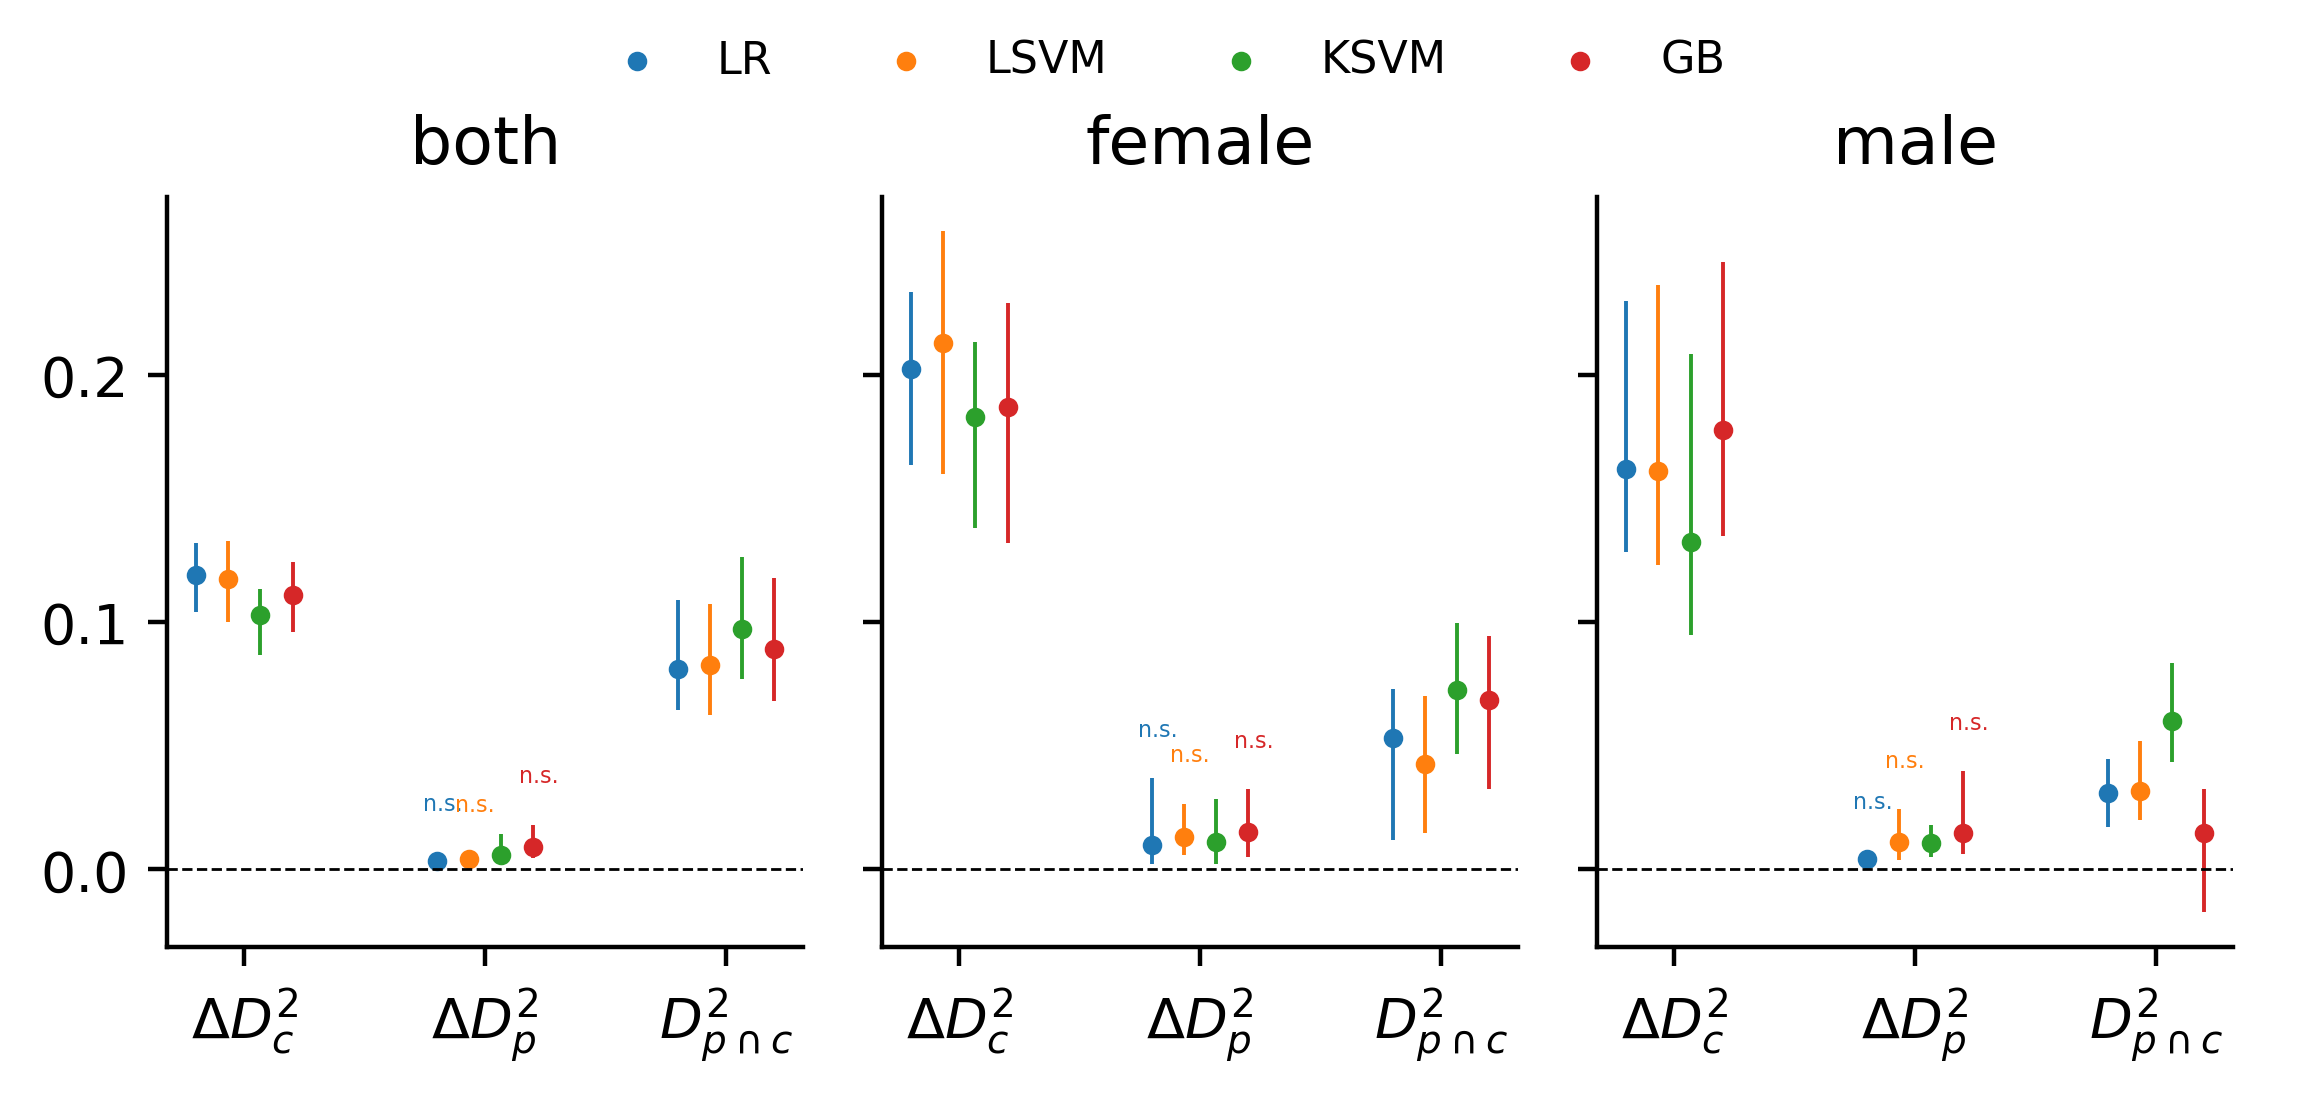

In [19]:
df = df_t1w.query("setting == 'id'")

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(6.3, 3), dpi=400, sharex=True, sharey=True)

for i, sex in enumerate(["both", "female", "male"]):
    dfx = df.query("sex == @sex")

    a = sns.pointplot(x="origin", y="mean", hue="model", data=dfx,\
             dodge=dodge, join=False, ax=ax[i], scale=posz)
    a.legend_.remove()
    ax[i].set_xticklabels(xtix)
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].set_title(sex)
    ax[i].axhline(y=0, c='k', ls='--', lw=0.5)
    
    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean()
    
    # Add errorbars and significance stars 
    for k, orig in enumerate(dfx["origin"].unique()):
        for m, model in enumerate(dfx["model"].unique()):

            dfxx = dfx.query("model == '{}' and origin == '{}'".format(model, orig))
            test_score = dfxx["mean"].values[0]
            ci_low = dfxx["low"].values[0]
            ci_high = dfxx["high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(k+dodge_[m], test_score, yerr=err, c=c[m], elinewidth=lisz)
            
            pvalue = dfxx["pvalue"].values[0]
            if (not np.isnan(pvalue)):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(k+dodge_[m]-0.06, ci_high+0.017,  r"{}".format(ast), c=c[m], fontsize=4)
                else:
                    ax[i].text(k+dodge_[m], ci_high+0.01, r"{}".format(ast), c=c[m], fontsize=6)

    
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

handles, _ = ax[i].get_legend_handles_labels()
#handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.85)
plt.show()

# DTI

In [20]:
idb = "../analysis/results/dti-FA_FU2-FU2_n789_z0.525_d0/20210227-0315"
prb = "../analysis/results/dti-FA_BL-FU2_n507_z0.525_d0/20210227-0240"

id1 = "../analysis/results/dti-FA_FU2-FU2_n403_sex1_z0.525_d0/20210227-0114"
pr1 = "../analysis/results/dti-FA_BL-FU2_n269_sex1_z0.525_d0/20210227-0208"

id0 = "../analysis/results/dti-FA_FU2-FU2_n386_sex0_z0.525_d0/20210227-0142"
pr0 = "../analysis/results/dti-FA_BL-FU2_n238_sex0_z0.525_d0/20210227-0225"

In [21]:
df_dti = pd.DataFrame()
df_pt = pd.read_csv("../analysis/results/dti-FA_FU2-FU2_n789_z0.525_d0/20210227-2223/pt.csv")
df_dti = df_dti.append(pbcc_results(idb, "DTI", "both", "id", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/dti-FA_FU2-FU2_n403_sex1_z0.525_d0/20210227-0747/pt.csv").query("model != 'SVC'")
df_pt = df_pt.append(pd.read_csv("../analysis/results/dti-FA_FU2-FU2_n403_sex1_z0.525_d0/20210304-1208/pt.csv").query("model != 'SVC'"))
df_dti = df_dti.append(pbcc_results(id1, "DTI", "female", "id", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/dti-FA_FU2-FU2_n386_sex0_z0.525_d0/20210228-1635/pt.csv")
df_dti = df_dti.append(pbcc_results(id0, "DTI", "male", "id", extra_pt=df_pt))

# Is still missing
df_pt = pd.read_csv("../analysis/results/dti-FA_BL-FU2_n507_z0.525_d0/20210301-1239/pt.csv").query("model == 'LogisticRegression'")
df_pt = df_pt.append(pd.read_csv("../analysis/results/dti-FA_BL-FU2_n507_z0.525_d0/20210304-1459/pt.csv"))
df_dti = df_dti.append(pbcc_results(prb, "DTI", "both", "pr", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/dti-FA_BL-FU2_n269_sex1_z0.525_d0/20210301-0111/pt.csv")
df_dti = df_dti.append(pbcc_results(pr1, "DTI", "female", "pr", extra_pt=df_pt))

df_pt = pd.read_csv("../analysis/results/dti-FA_BL-FU2_n238_sex0_z0.525_d0/20210301-0719/pt.csv")
df_dti = df_dti.append(pbcc_results(pr0, "DTI", "male", "pr", extra_pt=df_pt))

In [22]:
df_dti

,model,setting,inmod,sex,origin,mean,low,high,pvalue
0,LogisticRegression,id,DTI,both,conf,0.147638,0.123809,0.176901,NaN
1,LogisticRegression,id,DTI,both,pred,0.003816,0.001779,0.006220,0.229770
2,LogisticRegression,id,DTI,both,shared,0.052549,0.043063,0.060841,NaN
3,LinearSVC,id,DTI,both,conf,0.157928,0.133765,0.182843,NaN
4,LinearSVC,id,DTI,both,pred,0.001900,0.000993,0.003233,0.334665
...,...,...,...,...,...,...,...,...,...
7,SVC,pr,DTI,male,pred,0.017135,0.005478,0.043306,NaN
8,SVC,pr,DTI,male,shared,0.012258,-0.000425,0.031500,NaN
9,GradientBoostingClassifier,pr,DTI,male,conf,0.215771,0.187533,0.246322,NaN
10,GradientBoostingClassifier,pr,DTI,male,pred,0.020400,0.008989,0.036102,0.102897


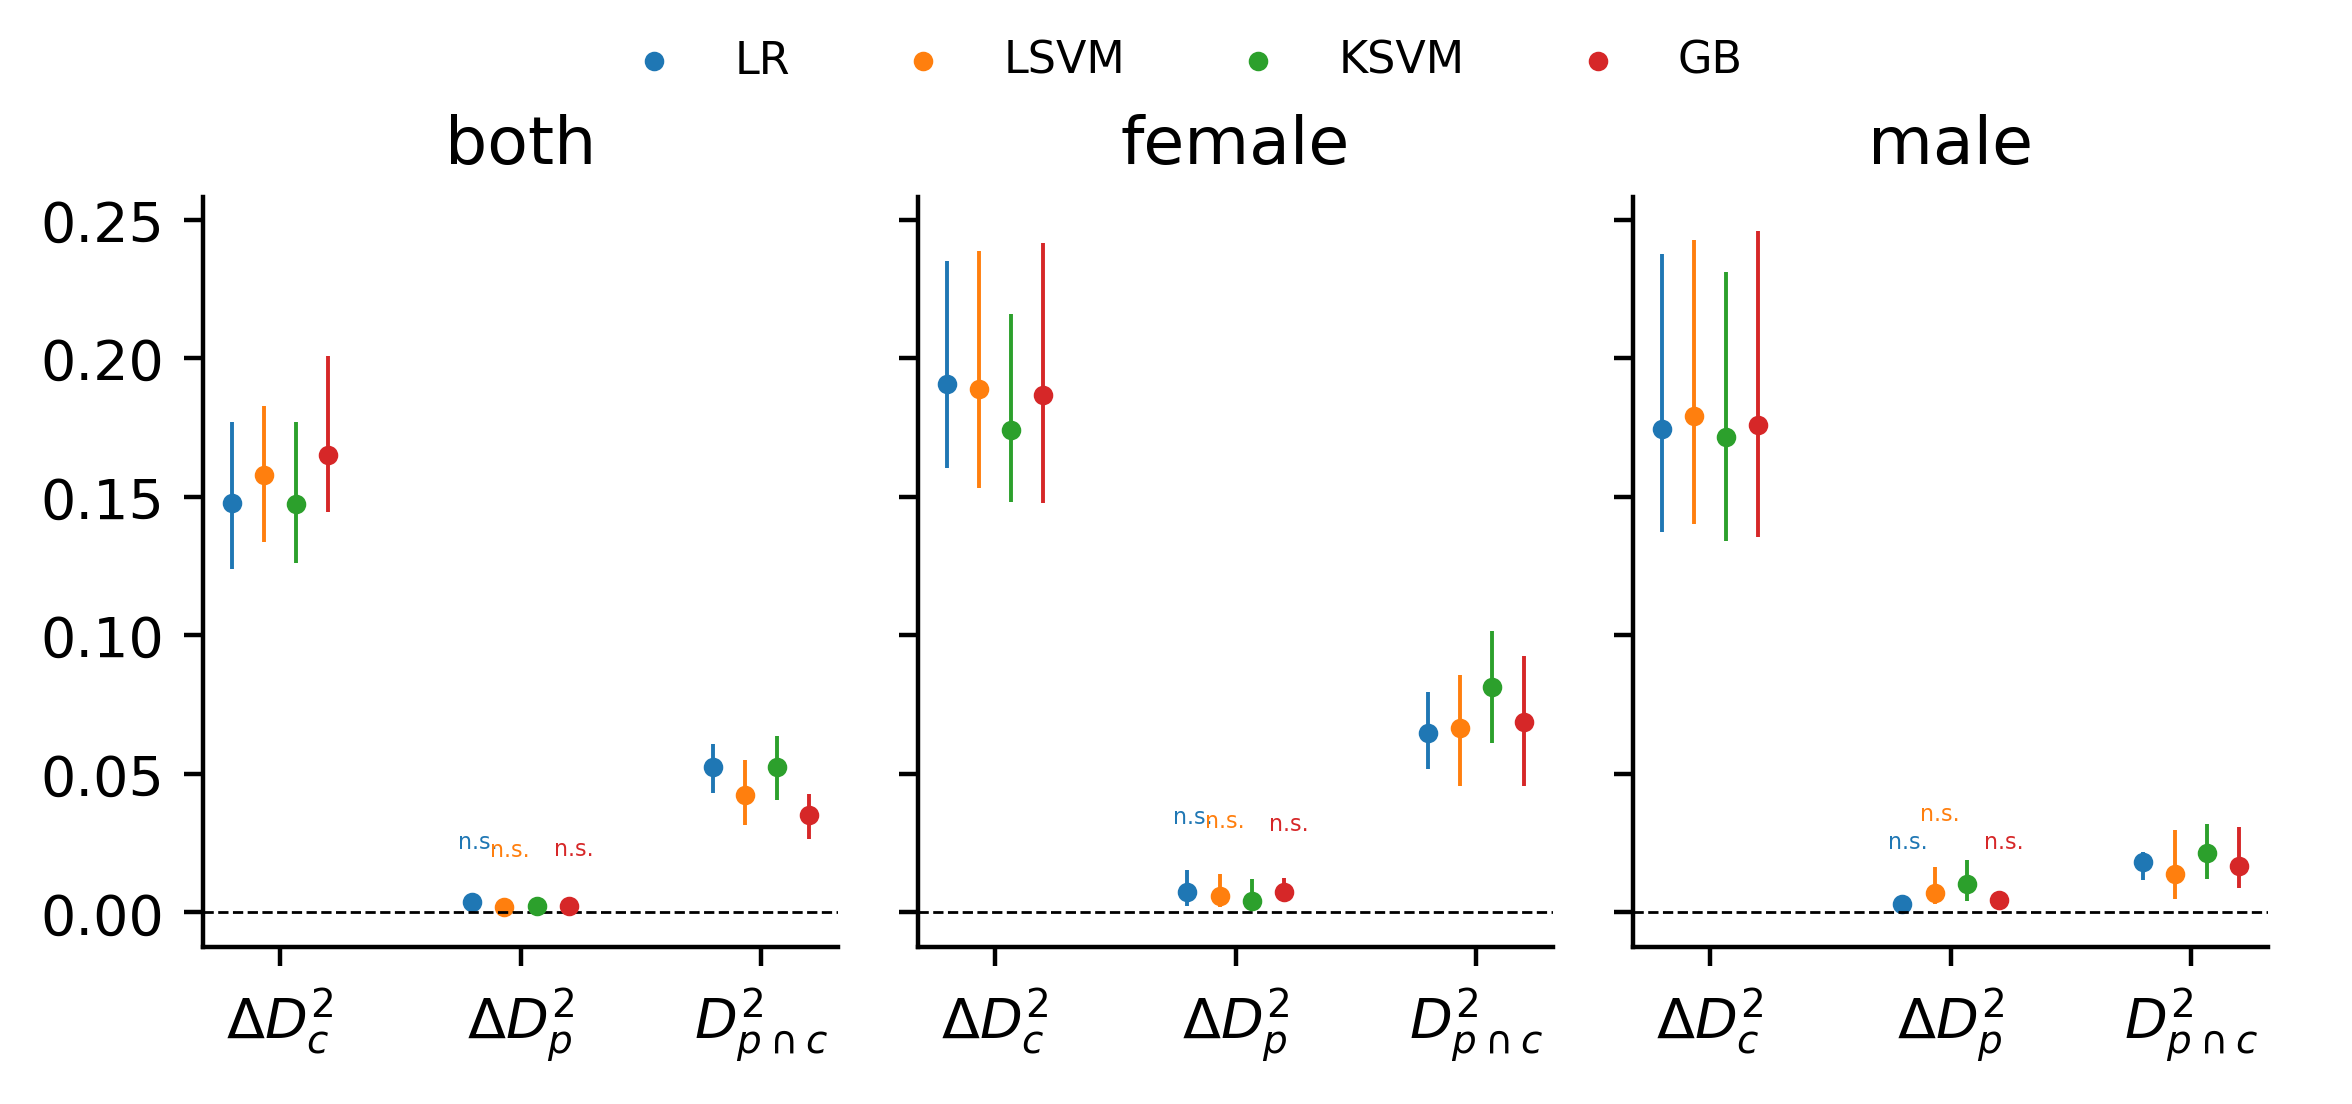

In [23]:
df = df_dti.query("setting == 'id'")

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(6.3, 3), dpi=400, sharex=True, sharey=True)

for i, sex in enumerate(["both", "female", "male"]):
    dfx = df.query("sex == @sex")

    a = sns.pointplot(x="origin", y="mean", hue="model", data=dfx,\
             dodge=dodge, join=False, ax=ax[i], scale=posz)
    a.legend_.remove()
    ax[i].set_xticklabels(xtix)
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].set_title(sex)
    ax[i].axhline(y=0, c='k', ls='--', lw=0.5)
    
    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean()
    
    # Add errorbars and significance stars 
    for k, orig in enumerate(dfx["origin"].unique()):
        for m, model in enumerate(dfx["model"].unique()):

            dfxx = dfx.query("model == '{}' and origin == '{}'".format(model, orig))
            test_score = dfxx["mean"].values[0]
            ci_low = dfxx["low"].values[0]
            ci_high = dfxx["high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(k+dodge_[m], test_score, yerr=err, c=c[m], elinewidth=lisz)
            
            pvalue = dfxx["pvalue"].values[0]
            if (not np.isnan(pvalue)):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(k+dodge_[m]-0.06, ci_high+0.017,  r"{}".format(ast), c=c[m], fontsize=4)
                else:
                    ax[i].text(k+dodge_[m], ci_high+0.01, r"{}".format(ast), c=c[m], fontsize=6)

    
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

handles, _ = ax[i].get_legend_handles_labels()
#handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.85)
plt.show()

# Big plot with all 

In [24]:
df = pd.DataFrame()
df = df.append(df_fss)
df = df.append(df_t1w)
df = df.append(df_dti)

df

,model,setting,inmod,sex,origin,mean,low,high,pvalue
0,LogisticRegression,id,fss,both,conf,0.119451,0.095201,0.152733,NaN
1,LogisticRegression,id,fss,both,pred,0.011283,0.004781,0.027032,0.059940
2,LogisticRegression,id,fss,both,shared,0.080735,0.065557,0.091396,NaN
3,LinearSVC,id,fss,both,conf,0.112318,0.092881,0.138749,NaN
4,LinearSVC,id,fss,both,pred,0.009701,0.003008,0.023909,0.093906
...,...,...,...,...,...,...,...,...,...
7,SVC,pr,DTI,male,pred,0.017135,0.005478,0.043306,NaN
8,SVC,pr,DTI,male,shared,0.012258,-0.000425,0.031500,NaN
9,GradientBoostingClassifier,pr,DTI,male,conf,0.215771,0.187533,0.246322,NaN
10,GradientBoostingClassifier,pr,DTI,male,pred,0.020400,0.008989,0.036102,0.102897


In [25]:
df.inmod.unique()

array(['fss', 'T1w', 'DTI'], dtype=object)

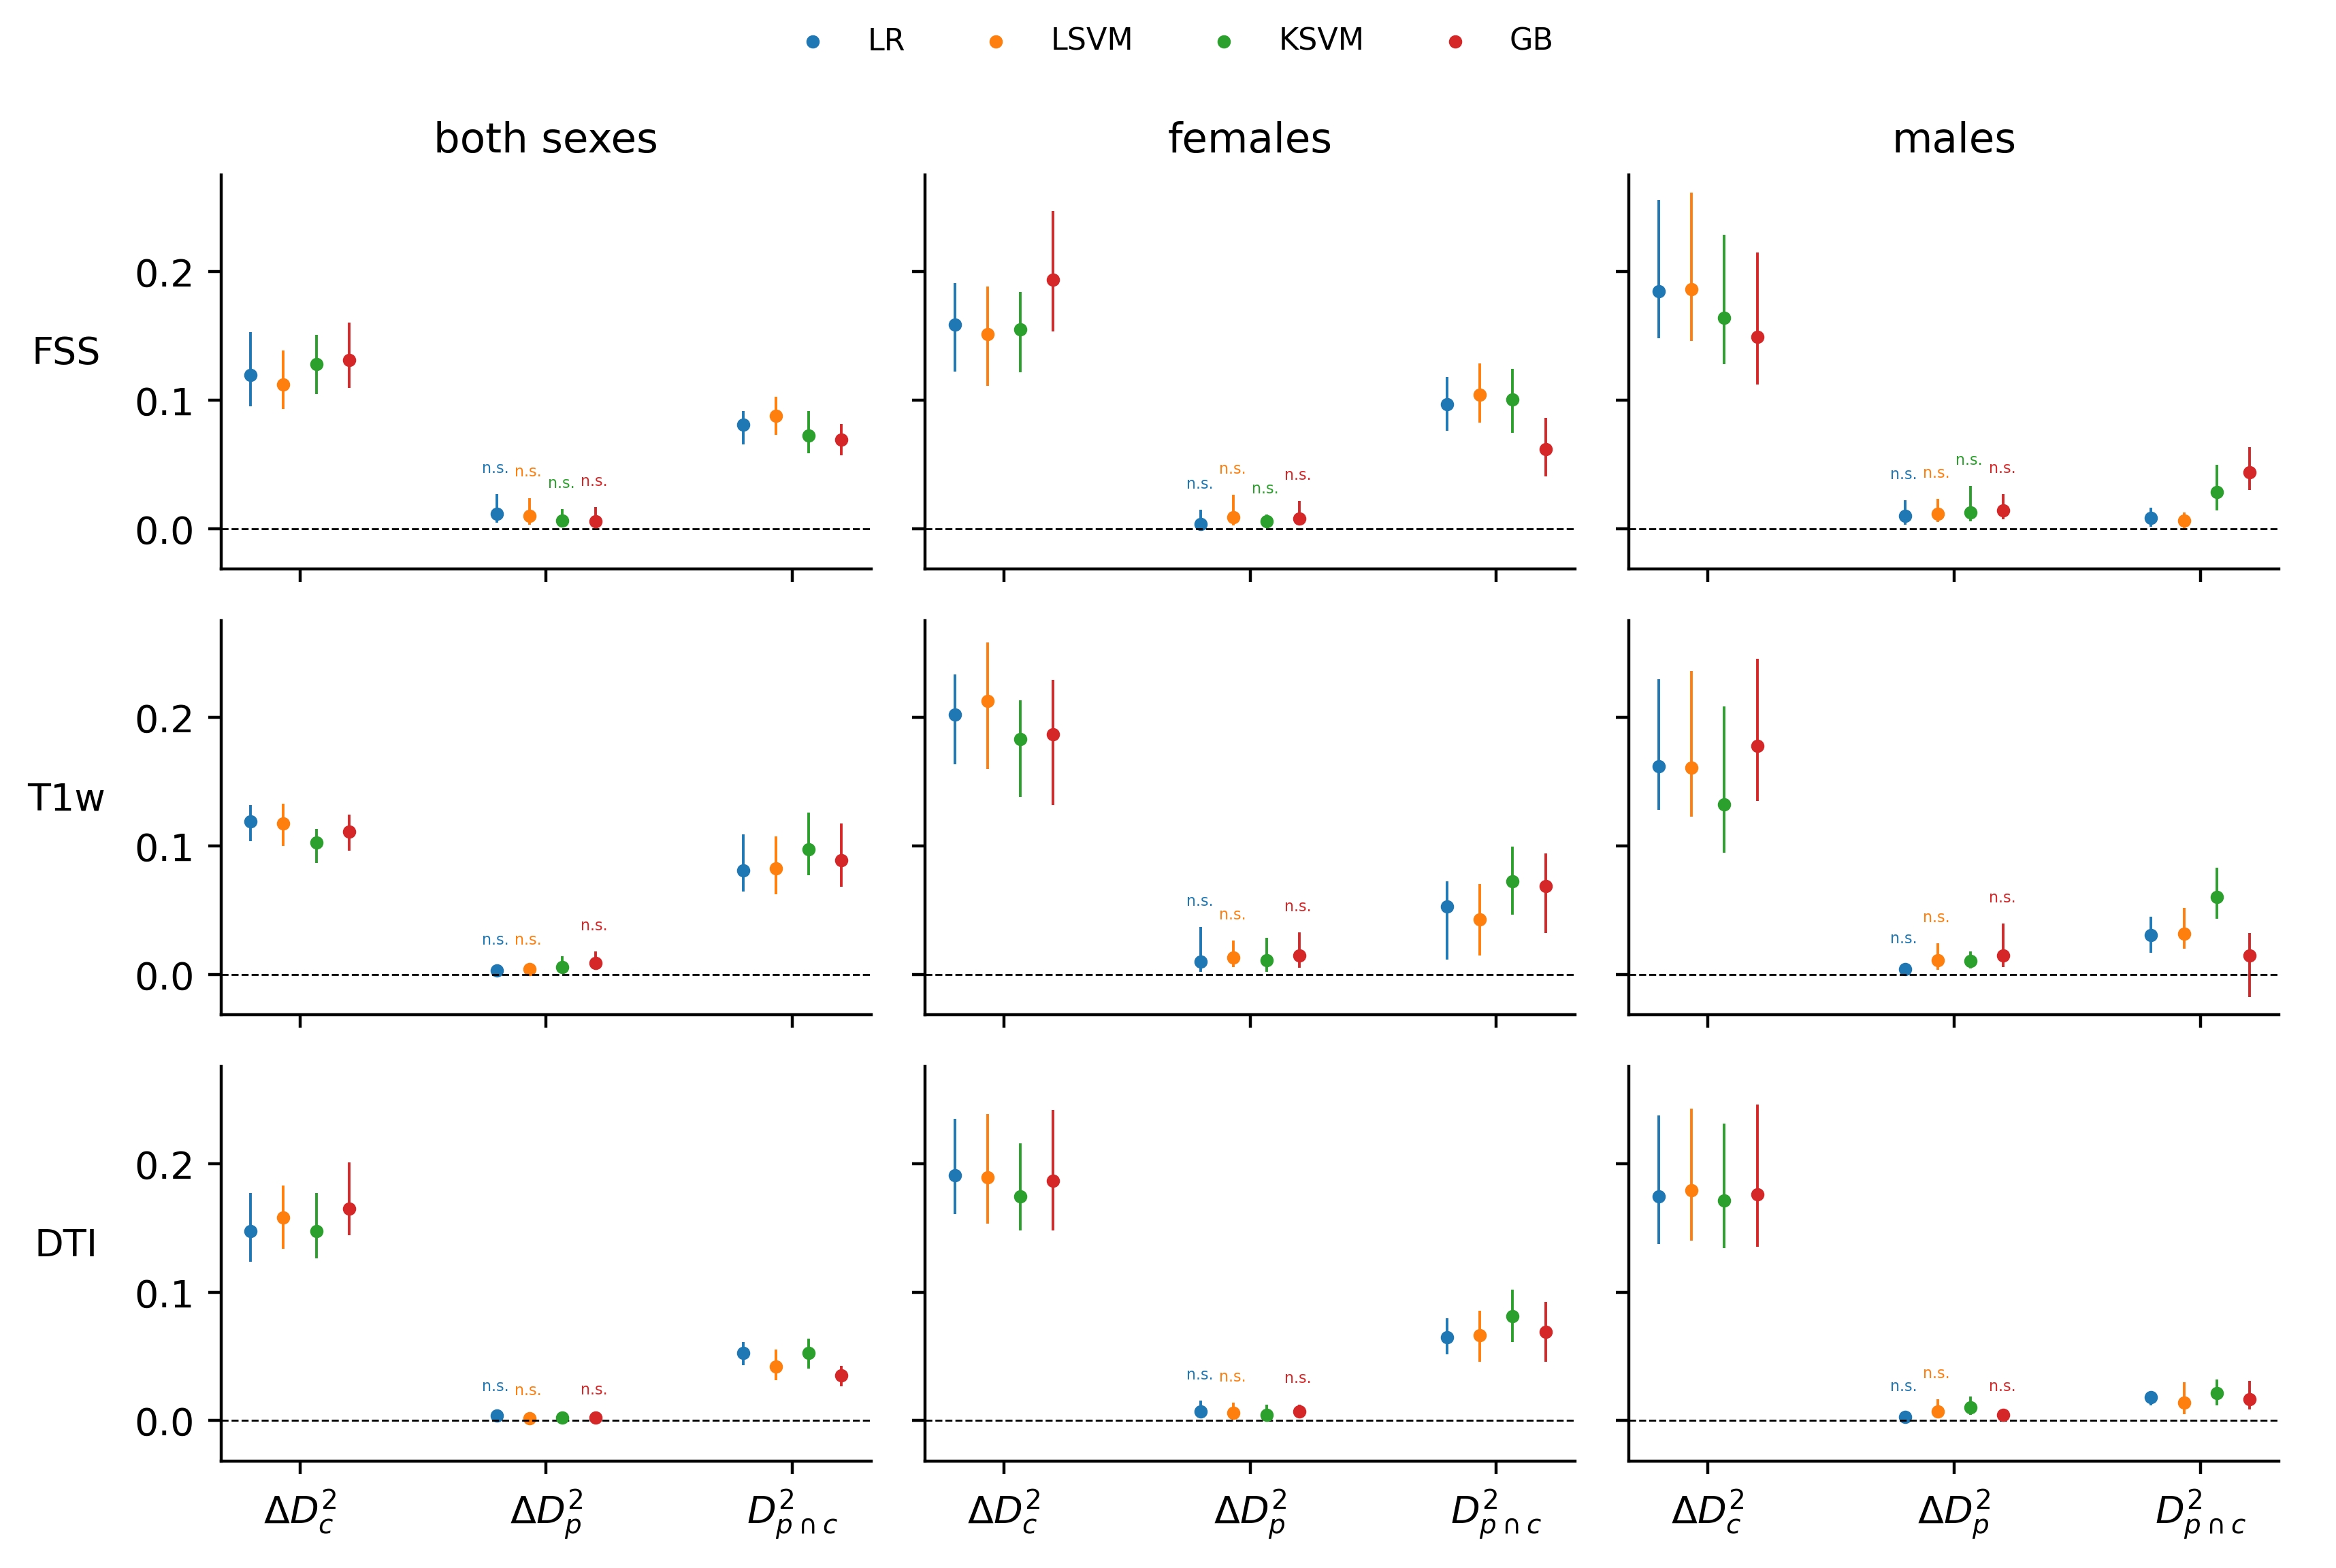

In [27]:
df = df.query("setting == 'id'")

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(9, 6), dpi=400, sharex=True, sharey=True)

for i, inmod in enumerate(["fss", "T1w", "DTI"]):
    for j, sex in enumerate(["both", "female", "male"]):
    
        dfx = df.query("sex == @sex and inmod == @inmod")

        a = sns.pointplot(x="origin", y="mean", hue="model", data=dfx,\
                 dodge=dodge, join=False, ax=ax[i,j], scale=posz)
        a.legend_.remove()
        ax[i,j].set_xticklabels(xtix)
        ax[i,j].set_ylabel("")
        ax[i,j].set_xlabel("")
        
        ax[i,j].axhline(y=0, c='k', ls='--', lw=0.5)

        n_models = len(dfx["model"].unique())
        dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean()

        # Add errorbars and significance stars 
        for k, orig in enumerate(dfx["origin"].unique()):
            for m, model in enumerate(dfx["model"].unique()):

                dfxx = dfx.query("model == '{}' and origin == '{}'".format(model, orig))
                test_score = dfxx["mean"].values[0]
                ci_low = dfxx["low"].values[0]
                ci_high = dfxx["high"].values[0]
                err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
                ax[i,j].errorbar(k+dodge_[m], test_score, yerr=err, c=c[m], elinewidth=lisz)

                pvalue = dfxx["pvalue"].values[0]
                if (not np.isnan(pvalue)):
                    ast = return_asterisks(pvalue)
                    if ast == "n.s.":
                        ax[i,j].text(k+dodge_[m]-0.06, ci_high+0.017,  r"{}".format(ast), c=c[m], fontsize=4)
                    else:
                        ax[i,j].text(k+dodge_[m], ci_high+0.01, r"{}".format(ast), c=c[m], fontsize=6)

    
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

handles, _ = ax[i,j].get_legend_handles_labels()
fig.legend(handles, ["LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

ax[0,0].set_title("both sexes", fontsize=11)
ax[0,1].set_title("females", fontsize=11)
ax[0,2].set_title("males", fontsize=11)

ax[0,0].set_ylabel("FSS", rotation=0, labelpad=18)
ax[1,0].set_ylabel("T1w", rotation=0, labelpad=18)
ax[2,0].set_ylabel("DTI", rotation=0, labelpad=18)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
df = pd.DataFrame()
df = df.append(df_fss)
df = df.append(df_t1w)
df = df.append(df_dti)
df = df.query("setting == 'pr'")

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6.3, 6), dpi=400, sharex=True, sharey=True)

for i, inmod in enumerate(["fss", "T1w", "DTI"]):
    for j, sex in enumerate(["both", "female", "male"]):
    
        dfx = df.query("sex == @sex and inmod == @inmod")

        a = sns.pointplot(x="origin", y="mean", hue="model", data=dfx,\
                 dodge=dodge, join=False, ax=ax[i,j], scale=posz)
        a.legend_.remove()
        ax[i,j].set_xticklabels(xtix)
        ax[i,j].set_ylabel("")
        ax[i,j].set_xlabel("")
        
        ax[i,j].axhline(y=0, c='k', ls='--', lw=0.5)

        n_models = len(dfx["model"].unique())
        dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean()

        # Add errorbars and significance stars 
        for k, orig in enumerate(dfx["origin"].unique()):
            for m, model in enumerate(dfx["model"].unique()):

                dfxx = dfx.query("model == '{}' and origin == '{}'".format(model, orig))
                test_score = dfxx["mean"].values[0]
                ci_low = dfxx["low"].values[0]
                ci_high = dfxx["high"].values[0]
                err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
                ax[i,j].errorbar(k+dodge_[m], test_score, yerr=err, c=c[m], elinewidth=lisz)

                pvalue = dfxx["pvalue"].values[0]
                if (not np.isnan(pvalue)):
                    ast = return_asterisks(pvalue)
                    if ast == "n.s.":
                        ax[i,j].text(k+dodge_[m]-0.06, ci_high+0.017,  r"{}".format(ast), c=c[m], fontsize=4)
                    else:
                        ax[i,j].text(k+dodge_[m], ci_high+0.01, r"{}".format(ast), c=c[m], fontsize=6)

    
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

handles, _ = ax[i,j].get_legend_handles_labels()
fig.legend(handles, ["LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

ax[0,0].set_title("both sexes", fontsize=11)
ax[0,1].set_title("females", fontsize=11)
ax[0,2].set_title("males", fontsize=11)

ax[0,0].set_ylabel("FSS", rotation=0, labelpad=18)
ax[1,0].set_ylabel("T1w", rotation=0, labelpad=18)
ax[2,0].set_ylabel("DTI", rotation=0, labelpad=18)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
df = df_fss
df = df.append(df_t1w)
df = df.append(df_dti)


df = df[["model", "setting", "inmod", "sex", "Dc_mean", "sh_mean", "Dp_mean", "Dp_pvalue"]]
df = df.reset_index(drop=True)
df = df.round(3)
df

In [ ]:
df.model = df.model.map({
        "LogisticRegression" : "LR", 
        "LinearSVC" : "LSVM", 
        "SVC" : "KSVM", 
        "GradientBoostingClassifier" : "GB", 
        "GaussianNB" : "NB"
    })

In [ ]:
df

In [ ]:
dfid = df.query("setting == 'id'")
dfid=dfid.reset_index(drop=True)

In [ ]:
dfid = dfid[["inmod", "sex", "model", "Dc_mean", "sh_mean", "Dp_mean", "Dp_pvalue"]]
dfid

In [ ]:
dfid.to_latex("pbcc_id.tex")

In [ ]:
dfpr = df.query("setting == 'pr'")
dfpr = dfpr.reset_index(drop=True)
dfpr = dfpr[["inmod", "sex", "model", "Dc_mean", "sh_mean", "Dp_mean", "Dp_pvalue"]]
dfpr

In [ ]:
dfpr.to_latex("pbcc_pr.tex")